[Home](index.ipynb) > [Notebooks](notebooks.ipynb) > Co-occurrences

<img style='float: left;' src='https://www.gesis.org/typo3conf/ext/gesis_web_ext/Resources/Public/webpack/dist/img/logo_gesis_en.svg' width='150'>

### ``compsoc`` – Computational Social Methods in Python

# Projecting bipartite occurrences to co-occurrences

**Author**: [Haiko Lietz](https://www.gesis.org/person/haiko.lietz)

**Affiliation**: [GESIS - Leibniz Institute for the Social Sciences](https://www.gesis.org/), Cologne, Germany

**Publication date**: XX.XX.XXXX (version 1.0)

***

## Introduction

Digital behavioral data is rich, which means, it offers many different ways to construct networks (e.g., persons or words as nodes). Sometimes, networks can be constructed directly from the data. Most often, this is the case when social relations are recorded, like a person calling another person. Often, things are not directly related but somehow occur in records of digital behavior, like words used in social media posts. **Occurrences** can be stored in a matrix and visualized as a bipartite network. Such a network is shown in the middle of **figure 1**. The network is bipartite because it consists of nodes of two types or modes: nodes from a set $U$ and nodes from a set $V$. The network shows how nodes from $V$ occur in nodes from $U$ and *vice versa*.

In a bipartite network, nodes do not have edges to other nodes from the same set. Such edges can be created by projecting the bipartite matrix to either side. For example, in a projection to the right side, nodes from $V$ will be connected if they co-occur in nodes from $U$. The result is a **co-occurrence** network with a corresponding matrix. This way, we can obtain the information, for example, how many times 

|<img src='images/bipartite.png' style='float: none; width: 450px'>|
|:--|
|<em style='float: center'>**Figure 1**: Social relations from the Copenhagen Networks Study</em>|

**In this notebook**, ...

## Dependencies and settings

In [1]:
import compsoc as cs
import graph_tool.all as gt
import numpy as np
import pandas as pd

In [2]:
#import warnings

In [3]:
#warnings.filterwarnings('ignore')

## Understanding the basic formalism

### Notation

Introduce example here

It could also be uses or words in documents or selections of hashtags in tweets.

...

Node set $U$:

In [4]:
numbers = [[0, '1'], [1, '2'], [2, '3'], [3, '4'], [4, '5']]
numbers = pd.DataFrame(numbers, columns=['number_id', 'number'])
numbers

,number_id,number
0,0,1
1,1,2
2,2,3
3,3,4
4,4,5


Node set $V$:

In [5]:
letters = [[0, 'a'], [1, 'b'], [2, 'c'], [3, 'd'], [4, 'e'], [5, 'f'], [6, 'g'], [7, 'h'], [8, 'i']]
letters = pd.DataFrame(letters, columns=['letter_id', 'letter'])
letters

,letter_id,letter
0,0,a
1,1,b
2,2,c
3,3,d
4,4,e
5,5,f
6,6,g
7,7,h
8,8,i


Finally, there are 15 edges. Note that all nodes in $U$ are connected to a different number of nodes in $V$; ``number_id=0`` connects to five nodes in $V$ are selected; ``number_id=1`` to four nodes; etc. Each edge also has a `weight`. Here we set it to 1 to be able to discuss the properties of projected networks. But in principle, weights can be any positive numerical:

In [6]:
occurrences = [[0, 0, 1], [0, 1, 1], [0, 2, 1], [0, 3, 1], [0, 4, 1], [1, 2, 1], [1, 3, 1], [1, 4, 1], [1, 5, 1], [2, 4, 1], [2, 5, 1], [2, 6, 1], [3, 6, 1], [3, 7, 1], [4, 8, 1]]
occurrences = pd.DataFrame(occurrences, columns=['number_id', 'letter_id', 'weight'])
occurrences

,number_id,letter_id,weight
0,0,0,1
1,0,1,1
2,0,2,1
3,0,3,1
4,0,4,1
5,1,2,1
6,1,3,1
7,1,4,1
8,1,5,1
9,2,4,1


The ``occurrences`` dataframe is the sparse form of the **bipartite matrix** $B$ with dimensionality $m\times n$. The bipartite matrix is an **occurrence matrix**. It is shown in the middle of figure 1.

The sum of weighted occurrences or the **total occurrence** is:

In [7]:
occurrences['weight'].sum()

15

The **occurrence** of nodes $i\in V$ is:

In [8]:
occurrences[['letter_id', 'weight']].groupby('letter_id').sum()

,weight
letter_id,
0,1
1,1
2,2
3,2
4,3
5,2
6,2
7,1
8,1


### Sparse matrices

We use the ``scipy.sparse`` package to handle matrices. It uses different formats to store information that have advantages and drawbacks for certain tasks. First, extract three lists that contain the rows, columns, and cell information for the matrix:

In [9]:
rows = occurrences['number_id'].tolist()
columns = occurrences['letter_id'].tolist()
weights = occurrences['weight'].tolist()

Then, build the matrix. For matrix construction, the [COOrdinate](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html) format is intended:

In [10]:
from scipy.sparse import coo_matrix

In [11]:
B = coo_matrix((weights, (rows, columns)), shape=(len(numbers), len(letters)))

In [12]:
type(B)

scipy.sparse._coo.coo_matrix

Technical summary of the matrix:

In [13]:
B.__dict__

{'_shape': (5, 9),
 'maxprint': 50,
 'row': array([0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4], dtype=int32),
 'col': array([0, 1, 2, 3, 4, 2, 3, 4, 5, 4, 5, 6, 6, 7, 8], dtype=int32),
 'data': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'has_canonical_format': False}

Easy-to-read summary:

In [14]:
print(B)

  (0, 0)	1
  (0, 1)	1
  (0, 2)	1
  (0, 3)	1
  (0, 4)	1
  (1, 2)	1
  (1, 3)	1
  (1, 4)	1
  (1, 5)	1
  (2, 4)	1
  (2, 5)	1
  (2, 6)	1
  (3, 6)	1
  (3, 7)	1
  (4, 8)	1


Row indices of selections can be accessed like this:

In [15]:
B.nonzero()[0]

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4], dtype=int32)

Column indices of selections can be accessed like this:

In [16]:
B.nonzero()[1]

array([0, 1, 2, 3, 4, 2, 3, 4, 5, 4, 5, 6, 6, 7, 8], dtype=int32)

Weights of selections can be accessed like this:

In [17]:
B.data

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Finally, a sparse matrix can be transformed into a dense array like this:

In [18]:
B.toarray()

array([[1, 1, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1]])

And if we want a nicer design, we can plot this array as a dataframe with a multiindex:

In [19]:
pd.DataFrame(B.toarray(), index=[['u']*len(numbers.index), numbers.index], columns=[['v']*len(letters.index), letters.index])

v                        
     0  1  2  3  4  5  6  7  8
u 0  1  1  1  1  1  0  0  0  0
  1  0  0  1  1  1  1  0  0  0
  2  0  0  0  0  1  1  1  0  0
  3  0  0  0  0  0  0  1  1  0
  4  0  0  0  0  0  0  0  0  1

### Matrix normalization

Consider an academic field where nodes in $U$ are **works**, nodes in $V$ are **authors**, and edges in $E$ are **authorships**. Further consider that the field is interdisciplinary: works in one discipline have 2 authors on average, and authors from another discipline have 5 authors on average. Intuitively, an author's contribution to a work is larger in the first discipline. By dividing an authorship by the number of authors of the corresponding work, this difference can be accounted for. Mathematically, this amounts to a row normalization of the bipartite matrix $B$. This way of normalizing selections has been proposed by Leydesdorff and Opthof (2010) for counting citations. Batagelj and Cerinšek (2013) have made it a pillar in their general (scientometric) matrix formalism that we use here.

For fast row normalization, we first transform $B$ to the [Compressed Sparse Row](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html) format:

In [20]:
B = B.tocsr()
B.__dict__

{'_shape': (5, 9),
 'maxprint': 50,
 'indices': array([0, 1, 2, 3, 4, 2, 3, 4, 5, 4, 5, 6, 6, 7, 8], dtype=int32),
 'indptr': array([ 0,  5,  9, 12, 14, 15], dtype=int32),
 'data': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 '_has_canonical_format': True,
 '_has_sorted_indices': True}

The row-normalized bipartite matrix is called $B^\mathrm{N}$:

In [21]:
from sklearn.preprocessing import normalize

In [22]:
BN = normalize(B, norm='l1', axis=1)

Display the normalized matrix:

In [23]:
pd.DataFrame(BN.toarray(), index=[['u']*len(numbers.index), numbers.index], columns=[['v']*len(letters.index), letters.index])

v                                                         
       0    1     2     3         4         5         6    7    8
u 0  0.2  0.2  0.20  0.20  0.200000  0.000000  0.000000  0.0  0.0
  1  0.0  0.0  0.25  0.25  0.250000  0.250000  0.000000  0.0  0.0
  2  0.0  0.0  0.00  0.00  0.333333  0.333333  0.333333  0.0  0.0
  3  0.0  0.0  0.00  0.00  0.000000  0.000000  0.500000  0.5  0.0
  4  0.0  0.0  0.00  0.00  0.000000  0.000000  0.000000  0.0  1.0

## Matrix projection

[Matrix multiplication](https://en.wikipedia.org/wiki/Matrix_multiplication) generally involves multiplications of the bipartite matrix with the transposed bipartite matrix which results in the cancellation of one mode of nodes. The **transposed matrix** of the bipartite matrix $B$ is called $B^\mathrm{T}$ and has dimensionality $n\times m$, which means, the rows (columns) of $B$ are its columns (rows). Similarly, the transpose of the normalized bipartite matrix $B^\mathrm{N}$ is $(B^\mathrm{N})^\mathrm{T}$.

Two projections can be obtained via matrix multiplication. When projecting $B$ to the $U$ mode, the information contained in $V$ is put into newly established edges among nodes in $U$. Similarly, when projecting $B$ to the $V$ mode, the information contained in $U$ is put into newly established edges among nodes in $V$.

If no matrix normalization is used, the projection of $B$ to the $U$ mode is equal to the projection of $B^\mathrm{T}$ to the $V$ mode. Here, we are only offering projections to the $V$ mode, some of which involve row normalizations, which have desirable mathematical properties (Batagelj and Cerinšek, 2013). Hence, it is up to the user to define the bipartite matrix $B$ in such a way that the desired projection is obtained.

### The first projection

The first projection does not use matrix normalization:

$G=B^\mathrm{T}\times B$

To obtain $G$, first transpose the bipartite matrix:

In [24]:
from scipy.sparse import csr_matrix

In [25]:
BT = csr_matrix.transpose(B)

Note that transposing a matrix in [Compressed Sparse Row](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html) format creates a matrix in [Compressed Sparse Column](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.html) format:

In [26]:
type(BT)

scipy.sparse._csc.csc_matrix

Then multiply the matrices to obtain the projection:

In [27]:
G = BT * B

The format of a projected matrix is determined by the format of the first factor:

In [28]:
type(G)

scipy.sparse._csc.csc_matrix

To correctly access indices and weights of $G$, it must be transformed from [Compressed Sparse Column](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.html) to [Compressed Sparse Row](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html) format:

In [29]:
G = G.tocsr()

Display $G$:

In [30]:
pd.DataFrame(G.toarray(), index=[['v']*len(letters.index), letters.index], columns=[['v']*len(letters.index), letters.index])

v                        
     0  1  2  3  4  5  6  7  8
v 0  1  1  1  1  1  0  0  0  0
  1  1  1  1  1  1  0  0  0  0
  2  1  1  2  2  2  1  0  0  0
  3  1  1  2  2  2  1  0  0  0
  4  1  1  2  2  3  2  1  0  0
  5  0  0  1  1  2  2  1  0  0
  6  0  0  0  0  1  1  2  1  0
  7  0  0  0  0  0  0  1  1  0
  8  0  0  0  0  0  0  0  0  1

$G$ is a **co-occurrence matrix** where weights $g_{ij}\in \mathbb{R}_{\geq0}$ are equal to the number of times node $i$ co-occurrs with $j$. Using the authorship example given above, the weights are equal to the number of works that authors $i$ and $j$ wrote together – hence, the projected matrix is a **co-authorship matrix**.

The diagonal of $G$ gives the number of times node $i$ co-occurrs with itself which is a node's occurrence as defined above. Regarding the example, the diagonal gives the number of works an author wrote in total (Batagelj and Cerinšek, 2013, pp. 850).

Extract the diagonal:

In [31]:
G.diagonal().tolist()

[1, 1, 2, 2, 3, 2, 2, 1, 1]

Since the matrix is symmetric, we can remove either triangular portion of the matrix. To remove a portion, transform the matrix into [COOrdinate](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html) format, ...

In [32]:
G = G.tocoo()

... remove the upper portion of the matrix using the ``triu()`` method (you could just as well use ``tril()`` to remove the lower portion), ...

In [33]:
from scipy.sparse import triu

In [34]:
G = triu(G)

... and transform the matrix back into [Compressed Sparse Row](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html) format:

In [35]:
G = G.tocsr()

#### The second projection

The second projection uses partial normalization:

$G^\mathrm{N1}=B^\mathrm{T}\times B^\mathrm{N}$

Construct $G^\mathrm{N1}$, transform and display it:

In [36]:
GN1 = BT * BN
GN1 = GN1.tocsr()
pd.DataFrame(GN1.toarray(), index=[['v']*len(letters.index), letters.index], columns=[['v']*len(letters.index), letters.index])

v                                                         
       0    1     2     3         4         5         6    7    8
v 0  0.2  0.2  0.20  0.20  0.200000  0.000000  0.000000  0.0  0.0
  1  0.2  0.2  0.20  0.20  0.200000  0.000000  0.000000  0.0  0.0
  2  0.2  0.2  0.45  0.45  0.450000  0.250000  0.000000  0.0  0.0
  3  0.2  0.2  0.45  0.45  0.450000  0.250000  0.000000  0.0  0.0
  4  0.2  0.2  0.45  0.45  0.783333  0.583333  0.333333  0.0  0.0
  5  0.0  0.0  0.25  0.25  0.583333  0.583333  0.333333  0.0  0.0
  6  0.0  0.0  0.00  0.00  0.333333  0.333333  0.833333  0.5  0.0
  7  0.0  0.0  0.00  0.00  0.000000  0.000000  0.500000  0.5  0.0
  8  0.0  0.0  0.00  0.00  0.000000  0.000000  0.000000  0.0  1.0

$G^\mathrm{N1}$ is a **partially normalized co-occurrence matrix**. The sum of its weights is equal to the total occurrence:

In [37]:
GN1.sum()

15.0

Weights $g_{ij}^\mathrm{N1}\in \mathbb{R}_{\geq0}$ are equal to the contribution of the corresponding edge to the total occurrence. In terms of the authorship example, weights give the contribution of a co-authorship relation to all authorships in the field, which is equal to the contribution of author $i$ to works co-authored with author $j$.

The diagonal of $G^\mathrm{N1}$ gives a node $i$'s contribution to its own occurrence, which we call its **self-occurrence**. In terms of the example, it's an author's contribution to the works he has authored (Batagelj and Cerinšek, 2013, pp. 854).

The self-occurrence of nodes $i\in V$ is:

In [38]:
self_occurrence = GN1.diagonal()
self_occurrence.tolist()

[0.2,
 0.2,
 0.45,
 0.45,
 0.7833333333333333,
 0.5833333333333333,
 0.8333333333333333,
 0.5,
 1.0]

The occurrence of nodes $i\in V$ can be recoverd by taking the row sum of $G^\mathrm{N1}$:

In [39]:
occurrence = GN1.sum(axis=0)
occurrence.tolist()[0]

[1.0, 1.0, 2.0, 2.0, 3.0000000000000004, 1.9999999999999998, 2.0, 1.0, 1.0]

The self-occurrence is always smaller or equal to the occurrence. Hence, we can construct an index that gives the **self-sufficiency** of nodes $i\in V$ (Batagelj and Cerinšek, 2013, p. 854):

In [40]:
self_sufficiency = self_occurrence / occurrence
self_sufficiency.tolist()[0]

[0.2,
 0.2,
 0.225,
 0.225,
 0.26111111111111107,
 0.2916666666666667,
 0.41666666666666663,
 0.5,
 1.0]

The closer the self-sufficiency to 1, the more a node self-contributes to its occurrence. A self-sufficiency of 1 means that other nodes do not contribute to its occurrence. In the authorship example, this would be an author that does not have any co-authors. It is isolated and not embedded. Hence, we can construct an index of the **embeddedness** of nodes $i\in V$, a measure of collaborativeness in the case of the authorship example (Batagelj and Cerinšek, 2013, p. 854):

In [41]:
embeddedness = 1 - self_sufficiency
embeddedness.tolist()[0]

[0.8,
 0.8,
 0.775,
 0.775,
 0.7388888888888889,
 0.7083333333333333,
 0.5833333333333334,
 0.5,
 0.0]

With these node attributes, we can enrich the ``node_list_v`` dataframe:

In [42]:
letters_enriched = letters.copy()
letters_enriched.loc[:, 'occurrence'] = occurrence.tolist()[0]
letters_enriched.loc[:, 'self-occurrence'] = self_occurrence.tolist()
letters_enriched.loc[:, 'self-sufficiency'] = self_sufficiency.tolist()[0]
letters_enriched.loc[:, 'embeddedness'] = embeddedness.tolist()[0]
letters_enriched

,letter_id,letter,occurrence,self-occurrence,self-sufficiency,embeddedness
0,0,a,1.0,0.200000,0.200000,0.800000
1,1,b,1.0,0.200000,0.200000,0.800000
2,2,c,2.0,0.450000,0.225000,0.775000
3,3,d,2.0,0.450000,0.225000,0.775000
4,4,e,3.0,0.783333,0.261111,0.738889
5,5,f,2.0,0.583333,0.291667,0.708333
6,6,g,2.0,0.833333,0.416667,0.583333
7,7,h,1.0,0.500000,0.500000,0.500000
8,8,i,1.0,1.000000,1.000000,0.000000


#### The third projection

The third projection uses full normalization:

$G^\mathrm{N2}=(B^\mathrm{N})^\mathrm{T}\times B^\mathrm{N}$

Transpose the normalized bipartite matrix, construct $G^\mathrm{N2}$, transform and display it:

In [43]:
BNT = csr_matrix.transpose(BN)
GN2 = BNT * BN
GN2 = GN2.tocsr()
pd.DataFrame(GN2.toarray(), index=[['v']*len(letters.index), letters.index], columns=[['v']*len(letters.index), letters.index])

v                                                               
        0     1       2       3         4         5         6     7    8
v 0  0.04  0.04  0.0400  0.0400  0.040000  0.000000  0.000000  0.00  0.0
  1  0.04  0.04  0.0400  0.0400  0.040000  0.000000  0.000000  0.00  0.0
  2  0.04  0.04  0.1025  0.1025  0.102500  0.062500  0.000000  0.00  0.0
  3  0.04  0.04  0.1025  0.1025  0.102500  0.062500  0.000000  0.00  0.0
  4  0.04  0.04  0.1025  0.1025  0.213611  0.173611  0.111111  0.00  0.0
  5  0.00  0.00  0.0625  0.0625  0.173611  0.173611  0.111111  0.00  0.0
  6  0.00  0.00  0.0000  0.0000  0.111111  0.111111  0.361111  0.25  0.0
  7  0.00  0.00  0.0000  0.0000  0.000000  0.000000  0.250000  0.25  0.0
  8  0.00  0.00  0.0000  0.0000  0.000000  0.000000  0.000000  0.00  1.0

$G^\mathrm{N2}$ is a **fully normalized co-occurrence matrix**. The sum of its weights is equal to the number of nodes in $U$, the number of works in the authorship example:

In [44]:
GN2.sum()

5.0

Due to full normalization, weights $g_{ij}^\mathrm{N2}\in \mathbb{R}_{[0,1]}$, which means, they are similarity scores of nodes $i$ and $j$ between 0 and 1. They are equal to the contribution of the corresponding edge to the size of $U$. In terms of the authorship example, weights give the contribution of a co-authorship relation to the number of works in the field.

It follows that the row sum of $G^\mathrm{N2}$ gives a node $i$'s contribution to its own occurrence (an author's contribution to the works he has authored), which we have called its self-occurrence above:

In [45]:
GN2.sum(axis=0).tolist()[0]

[0.20000000000000004,
 0.20000000000000004,
 0.45000000000000007,
 0.45000000000000007,
 0.7833333333333334,
 0.5833333333333333,
 0.8333333333333333,
 0.5,
 1.0]

### Summary



FROM HERE ON: REFINE TEXT

<div class='alert alert-warning'>
<big><b>Caution</b></big>

It is important to understand the effects of matrix normalization as we have discussed it so far. For example, a strong co-selection of two facts can result from few transactions in which few facts are co-selected or from many transactions in which many facts are co-selected. Matrix normalization complicates interpretability when the number of selections per transaction exhibits large variance. In small-data settings, it may therefore be advised to not use matrix normalization. In big-data settings, it may be possible to remove outlier transactions with exceptionally many selections (e.g., publications with either very short or very long reference lists).
</div>

## Cumulative co-occurrence fractions
Sometimes it is can be helpful to filter graphs, e.g., to uncover a pattern that may otherwise be hidden in relational "noise". An observer of a meaning structure may neglect weak ties to identify the core facts of the field. Hence, removing weakly selected nodes or edges is not only a step we can do as network analysts, but an analytical step towards understanding what an observer in a field may have observed as he or she was trying to reduce uncertainty.

As an alternative to simply filtering edges with small weights, one can keep those co-selections that collectively account for a specified amount of attention in the field. For this purpose we enrich edges by **cumulative fractions** of total matrix weights.

First, distinct edge weights and the weight (attention) they collectively account for are identified. In the toy example, a single co-selection tie with a ``weight == 1`` also accounts for a total weight of 1. But 16 co-selection ties with ``weight == 0.2`` account for a total weight of 3.2:

The edge list of $G^\mathrm{N1}$ is:

In [46]:
co_occurrences_letters_n1 = pd.concat([
    pd.Series(GN1.nonzero()[0]), 
    pd.Series(GN1.nonzero()[1]), 
    pd.Series(GN1.data)
], axis=1)
co_occurrences_letters_n1.columns = ['letter_id_i', 'letter_id_j', 'weight']
co_occurrences_letters_n1.head()

,letter_id_i,letter_id_j,weight
0,0,0,0.2
1,0,1,0.2
2,0,2,0.2
3,0,3,0.2
4,0,4,0.2


In [47]:
directed = False
remove_self_loops = False

if directed == False:
    co_occurrences_letters_n1 = co_occurrences_letters_n1[co_occurrences_letters_n1['letter_id_j'] >= co_occurrences_letters_n1['letter_id_i']]
if remove_self_loops == True:
    co_occurrences_letters_n1 = co_occurrences_letters_n1[co_occurrences_letters_n1['letter_id_j'] != co_occurrences_letters_n1['letter_id_i']]

co_occurrences_letters_n1.head()

,letter_id_i,letter_id_j,weight
0,0,0,0.2
1,0,1,0.2
2,0,2,0.2
3,0,3,0.2
4,0,4,0.2


In [48]:
co_occurrences_letters_n1_cumfrac = co_occurrences_letters_n1['weight'].groupby(co_occurrences_letters_n1['weight']).sum().sort_index(ascending=False)
co_occurrences_letters_n1_cumfrac

weight
1.000000    1.000000
0.833333    0.833333
0.783333    0.783333
0.583333    1.166667
0.500000    1.000000
0.450000    2.250000
0.333333    0.666667
0.250000    0.500000
0.200000    1.800000
Name: weight, dtype: float64

Second, the summed weights are turned into cumulative co-selection fractions ``cumfrac`` such that all weights at least as strong as the smallest one account for 100 percent of the attention in the whole field. In the toy example, if we wanted to keep those co-selections that account for no more than 75 percent of the attention (``cumfrac <= .75``), we would have to remove all edges with ``weight < 0.3333``:

In [49]:
co_occurrences_letters_n1_cumfrac = co_occurrences_letters_n1_cumfrac.cumsum() / sum(co_occurrences_letters_n1_cumfrac)
co_occurrences_letters_n1_cumfrac = co_occurrences_letters_n1_cumfrac.round(6)
co_occurrences_letters_n1_cumfrac.rename('cumfrac', inplace=True)

weight
1.000000    0.100000
0.833333    0.183333
0.783333    0.261667
0.583333    0.378333
0.500000    0.478333
0.450000    0.703333
0.333333    0.770000
0.250000    0.820000
0.200000    1.000000
Name: cumfrac, dtype: float64

The cumulative fractions can then be merged back into the co-selection dataframe:

In [50]:
co_occurrences_letters_n1 = pd.merge(left=co_occurrences_letters_n1, right=co_occurrences_letters_n1_cumfrac, left_on='weight', right_on=co_occurrences_letters_n1_cumfrac.index)
co_occurrences_letters_n1.head()

,letter_id_i,letter_id_j,weight,cumfrac
0,0,0,0.2,1.0
1,0,1,0.2,1.0
2,0,2,0.2,1.0
3,0,3,0.2,1.0
4,0,4,0.2,1.0


Apply the edge filter, construct and draw the filtered graph:

In [51]:
gn1_filter = cs.construct_graph(
    node_list = letters, 
    edge_list = co_occurrences_letters_n1[co_occurrences_letters_n1['cumfrac'] <= .75], 
    node_identifier = 'letter_id', 
    directed = directed, 
    graph_name = 'gn1_filter', 
    node_properties = ['letter'], 
    node_property_types = ['string'], 
    edge_properties = ['weight'], 
    edge_property_types = ['double']
)

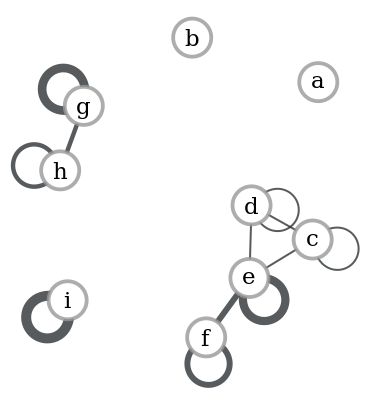

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f186da2eb90, at 0x7f18c67b0bd0>

In [52]:
#from matplotlib.cm import get_cmap

gt.graph_draw(
    g = gn1_filter, 
    vertex_text = gn1_filter.vp.letter, 
    vertex_fill_color = 'white', 
    edge_pen_width = gt.prop_to_size(gn1_filter.ep.weight, 1, 5), 
    #edge_color = gn1_filter.ep.weight, 
    #ecmap = get_cmap('binary'), 
    output_size = (200, 200)
)

## Function

...

In [53]:
#def co_occurrence(
#    node_list_u, 
#    node_list_v, 
#    edge_list, 
#    node_u_identifier, 
#    node_v_identifier, 
#    weight, 
#    norm, 
#    directed = False, 
#    remove_self_loops = True, 
#    enrich_node_list_v = True
#):
#    '''
#    Description: Constructs a unipartite co-occurrence matrix from pandas node lists 
#        representing the two sets U and V and an edge list E representing a bipartite 
#        occurrence matrix by projecting E to the V side, possibly using normalization.
#    
#    Inputs:
#        node_list_u: pandas dataframe containing the identifiers and properties of node in 
#            the set U; must contain a continuous identifier from 0 to N-1 where N is the 
#            number of vertices; node attributes must be in additional columns.
#        node_list_v: pandas dataframe containing the identifiers and properties of node in 
#            the set V; must contain a continuous identifier from 0 to N-1 where N is the 
#            number of vertices; node attributes must be in additional columns.
#        edge_list: pandas dataframe representing the occurrence matrix; must contain a U 
#            and V node identifier pair per occurrence or edge.
#        node_u_identifier: Column name of the U node list that contains the node identifier.
#        node_v_identifier: Column name of the V node list that contains the node identifier.
#        weight: Column name of the edge list that contains the weight of an occurrence; 
#            if None, it is set to 1.
#        norm: Kind of normalization to be used in projecting the co-occurrence matrix; 
#            if None, no normalization is used; if 'partial', partial row normalization is 
#            used; if 'full', full row normalization is used.
#        directed: If co-occurrence should be directed (boolean); set to False by default.
#        remove_self_loops: If values in the diagonal of the co-occurrence matrix should 
#            be removed (boolean); set to True by default.
#        enrich_node_list_v: If node attributes from matrix projection (e.g., occurrence, 
#            self-occurrence) should be stored in the node list representing V.
#    
#    Output: Unipartite matrix in form of a pandas dataframe or edge list giving weighted 
#        co-occurrences.
#    '''
#    import pandas as pd
#    from scipy.sparse import coo_matrix, csr_matrix
#    
#    # node list checks
#    node_list_u = node_list_u.sort_values(node_u_identifier, ascending=True).reset_index(drop=True)
#    node_list_v = node_list_v.sort_values(node_v_identifier, ascending=True).reset_index(drop=True)
#    check_u = node_list_u[node_u_identifier] == node_list_u.index
#    check_v = node_list_v[node_v_identifier] == node_list_v.index
#    if (sum(check_u) == len(node_list_u)) == False:
#        print('The node list dataframe of set U does not meet the requirements. Check if the'+node_identifier+'column contains integers from zero to N-1 where N is the number of vertices in the graph.')
#    if (sum(check_v) == len(node_list_v)) == False:
#        print('The node list dataframe of set V does not meet the requirements. Check if the'+node_identifier+'column contains integers from zero to N-1 where N is the number of vertices in the graph.')
#    
#    # construct occurrence matrix
#    rows = edge_list[node_u_identifier].tolist()
#    columns = edge_list[node_v_identifier].tolist()
#    if weight:
#        weights = edge_list[weight].tolist()
#    else:
#        weights = [1] * len(edge_list)
#    B = coo_matrix((weights, (rows, columns)), shape=(len(node_list_u), len(node_list_v))).tocsr()
#    BT = csr_matrix.transpose(B)
#    
#    # construct co-occurrence matrix
#    if norm == None:
#        G = (BT * B).tocsr()
#        if enrich_node_list_v:
#            node_list_v.loc[:, 'occurrence'] = G.diagonal().tolist()
#    elif norm == 'partial':
#        from sklearn.preprocessing import normalize
#        BN = normalize(B, norm='l1', axis=1)
#        G = (BT * BN).tocsr()
#        if enrich_node_list_v:
#            node_list_v.loc[:, 'occurrence'] = G.sum(axis=0).tolist()[0]
#            node_list_v.loc[:, 'self-occurrence'] = G.diagonal().tolist()
#            node_list_v.loc[:, 'self-sufficiency'] = node_list_v['self-occurrence'] / node_list_v['occurrence']
#            node_list_v.loc[:, 'embeddedness'] = 1 - node_list_v['self-sufficiency']
#    elif norm == 'full':
#        from sklearn.preprocessing import normalize
#        BN = normalize(B, norm='l1', axis=1)
#        BNT = csr_matrix.transpose(BN)
#        G = (BNT * BN).tocsr()
#        if enrich_node_list_v:
#            node_list_v.loc[:, 'self-occurrence'] = G.sum(axis=0).tolist()[0]
#    
#    # construct co-occurrence edge list with cumulative fractions
#    edge_list_v = pd.concat([pd.Series(G.nonzero()[0]), pd.Series(G.nonzero()[1]), pd.Series(G.data)], axis=1)
#    edge_list_v.columns = [node_v_identifier+'_i', node_v_identifier+'_j', 'weight']
#    if directed == False:
#        edge_list_v = edge_list_v[edge_list_v[node_v_identifier+'_j'] >= edge_list_v[node_v_identifier+'_i']]
#    if remove_self_loops == True:
#        edge_list_v = edge_list_v[edge_list_v[node_v_identifier+'_j'] != edge_list_v[node_v_identifier+'_i']]
#    edge_list_v_cumfrac = edge_list_v['weight'].groupby(edge_list_v['weight']).sum().sort_index(ascending=False)
#    edge_list_v_cumfrac = (edge_list_v_cumfrac.cumsum() / sum(edge_list_v_cumfrac)).round(6)
#    edge_list_v_cumfrac.rename('cumfrac', inplace=True)
#    edge_list_v = pd.merge(left=edge_list_v, right=edge_list_v_cumfrac, left_on='weight', right_on=edge_list_v_cumfrac.index)
#    
#    return edge_list_v
#
#def co_occurrence_category(
#    node_list_u, 
#    node_list_v, 
#    edge_list, 
#    node_u_identifier, 
#    node_v_identifier, 
#    category_identifier, 
#    weight, 
#    norm, 
#    directed = False, 
#    remove_self_loops = True
#):
#    '''
#    Description: Constructs a unipartite co-occurrence matrix from pandas node lists 
#        representing the two sets U and V and an edge list E representing a bipartite 
#        occurrence matrix by projecting E to the V side, possibly using normalization, 
#        for the special case where occurrences belong to distinct categories.
#    
#    Inputs:
#        node_list_u: pandas dataframe containing the identifiers and properties of node in 
#            the set U; must contain a continuous identifier from 0 to N-1 where N is the 
#            number of vertices; node attributes must be in additional columns.
#        node_list_v: pandas dataframe containing the identifiers and properties of node in 
#            the set V; must contain a continuous identifier from 0 to N-1 where N is the 
#            number of vertices; node attributes must be in additional columns.
#        edge_list: pandas dataframe representing the occurrence matrix; must contain a U 
#            and V node identifier pair per occurrence or edge.
#        node_u_identifier: Column name of the U node list that contains the node identifier.
#        node_v_identifier: Column name of the V node list that contains the node identifier.
#        category_identifier: Column name of the edge list that tells which category an 
#            occurrence belongs to.
#        weight: Column name of the edge list that contains the weight of an occurrence; 
#            if None, it is set to 1.
#        norm: Kind of normalization to be used in projecting the co-occurrence matrix; 
#            if None, no normalization is used; if 'partial', partial row normalization is 
#            used; if 'full', full row normalization is used.
#        directed: If co-occurrence should be directed (boolean); set to False by default.
#        remove_self_loops: If values in the diagonal of the co-occurrence matrix should 
#            be removed (boolean); set to True by default.
#    
#    Output: Unipartite matrix in form of a pandas dataframe or edge list giving weighted 
#        and categorized co-occurrences.
#    '''
#    import pandas as pd
#    
#    categories = edge_list[category_identifier].drop_duplicates().sort_values().tolist()
#    edge_list_v = pd.DataFrame(columns=[node_v_identifier+'_i', node_v_identifier+'_j', category_identifier, 'weight', 'cumfrac'], dtype='int')
#    for category in categories:
#        edge_list_v_category = co_occurrence(node_list_u=node_list_u, node_list_v=node_list_v, edge_list=edge_list[edge_list[category_identifier]==category], node_u_identifier=node_u_identifier, node_v_identifier=node_v_identifier, weight=weight, norm=norm, directed=directed, remove_self_loops=remove_self_loops, enrich_node_list_v=False)
#        edge_list_v_category.loc[:, category_identifier] = category
#        edge_list_v_category = edge_list_v_category[[node_v_identifier+'_i', node_v_identifier+'_j', category_identifier, 'weight', 'cumfrac']]
#        edge_list_v = pd.concat([edge_list_v, edge_list_v_category])
#    
#    return edge_list_v

def co_occurrence(
    node_list_u, 
    node_list_v, 
    edge_list, 
    node_u_identifier, 
    node_v_identifier, 
    weight, 
    norm, 
    category_identifier = None, 
    directed = False, 
    remove_self_loops = True, 
    enrich_node_list_v = False
):
    '''
    Description: Constructs a unipartite co-occurrence matrix from pandas node lists 
        representing the two sets U and V and an edge list E representing a bipartite 
        occurrence matrix by projecting E to the V side, possibly using normalization.
    
    Inputs:
        node_list_u: pandas dataframe containing the identifiers and properties of node in 
            the set U; must contain a continuous identifier from 0 to N-1 where N is the 
            number of vertices; node attributes must be in additional columns.
        node_list_v: pandas dataframe containing the identifiers and properties of node in 
            the set V; must contain a continuous identifier from 0 to N-1 where N is the 
            number of vertices; node attributes must be in additional columns.
        edge_list: pandas dataframe representing the occurrence matrix; must contain a U 
            and V node identifier pair per occurrence or edge.
        node_u_identifier: Column name of the U node list that contains the node identifier.
        node_v_identifier: Column name of the V node list that contains the node identifier.
        weight: Column name of the edge list that contains the weight of an occurrence; 
            if None, it is set to 1.
        norm: Kind of normalization to be used in projecting the co-occurrence matrix; 
            if None, no normalization is used; if 'partial', partial row normalization is 
            used; if 'full', full row normalization is used.
        category_identifier: Column name of the edge list that tells which category an 
            occurrence belongs to; set to None by default.
        directed: If co-occurrence should be directed (boolean); set to False by default.
        remove_self_loops: If values in the diagonal of the co-occurrence matrix should 
            be removed (boolean); set to True by default.
        enrich_node_list_v: If node attributes from matrix projection (e.g., occurrence, 
            self-occurrence) should be stored in the node list representing V; set to False 
            by default.
    
    Output: Unipartite matrix in form of a pandas dataframe or edge list giving weighted 
        co-occurrences.
    '''
    import pandas as pd
    from scipy.sparse import coo_matrix, csr_matrix
    
    if category_identifier:
        import compsoc as cs
        
        # call compsoc function
        if enrich_node_list_v:
            print("Node list can't be enriched because co-occurrences are computed for categories.")
        categories = edge_list[category_identifier].drop_duplicates().sort_values().tolist()
        edge_list_v = pd.DataFrame(columns=[node_v_identifier+'_i', node_v_identifier+'_j', category_identifier, 'weight', 'cumfrac'], dtype='int')
        for category in categories:
            edge_list_v_category = cs.co_occurrence(node_list_u=node_list_u, node_list_v=node_list_v, edge_list=edge_list[edge_list[category_identifier]==category], node_u_identifier=node_u_identifier, node_v_identifier=node_v_identifier, category_identifier=None, weight=weight, norm=norm, directed=directed, remove_self_loops=remove_self_loops, enrich_node_list_v=False)
            edge_list_v_category.loc[:, category_identifier] = category
            edge_list_v_category = edge_list_v_category[[node_v_identifier+'_i', node_v_identifier+'_j', category_identifier, 'weight', 'cumfrac']]
            edge_list_v = pd.concat([edge_list_v, edge_list_v_category])
    else:
        # node list checks
        node_list_u = node_list_u.sort_values(node_u_identifier, ascending=True).reset_index(drop=True)
        node_list_v = node_list_v.sort_values(node_v_identifier, ascending=True).reset_index(drop=True)
        check_u = node_list_u[node_u_identifier] == node_list_u.index
        check_v = node_list_v[node_v_identifier] == node_list_v.index
        if (sum(check_u) == len(node_list_u)) == False:
            print('The node list dataframe of set U does not meet the requirements. Check if the'+node_identifier+'column contains integers from zero to N-1 where N is the number of vertices in the graph.')
        if (sum(check_v) == len(node_list_v)) == False:
            print('The node list dataframe of set V does not meet the requirements. Check if the'+node_identifier+'column contains integers from zero to N-1 where N is the number of vertices in the graph.')
        
        # construct occurrence matrix
        rows = edge_list[node_u_identifier].tolist()
        columns = edge_list[node_v_identifier].tolist()
        if weight:
            weights = edge_list[weight].tolist()
        else:
            weights = [1] * len(edge_list)
        B = coo_matrix((weights, (rows, columns)), shape=(len(node_list_u), len(node_list_v))).tocsr()
        BT = csr_matrix.transpose(B)
        
        # construct co-occurrence matrix
        if norm == None:
            G = (BT * B).tocsr()
            if enrich_node_list_v:
                print('Enriching...')
                node_list_v.loc[:, 'occurrence'] = G.diagonal().tolist()
        elif norm == 'partial':
            from sklearn.preprocessing import normalize
            BN = normalize(B, norm='l1', axis=1)
            G = (BT * BN).tocsr()
            if enrich_node_list_v:
                print('Enriching...')
                node_list_v.loc[:, 'occurrence'] = G.sum(axis=0).tolist()[0]
                node_list_v.loc[:, 'self-occurrence'] = G.diagonal().tolist()
                node_list_v.loc[:, 'self-sufficiency'] = node_list_v['self-occurrence'] / node_list_v['occurrence']
                node_list_v.loc[:, 'embeddedness'] = 1 - node_list_v['self-sufficiency']
        elif norm == 'full':
            from sklearn.preprocessing import normalize
            BN = normalize(B, norm='l1', axis=1)
            BNT = csr_matrix.transpose(BN)
            G = (BNT * BN).tocsr()
            if enrich_node_list_v:
                print('Enriching...')
                node_list_v.loc[:, 'self-occurrence'] = G.sum(axis=0).tolist()[0]
        
        # construct co-occurrence edge list with cumulative fractions
        edge_list_v = pd.concat([pd.Series(G.nonzero()[0]), pd.Series(G.nonzero()[1]), pd.Series(G.data)], axis=1)
        edge_list_v.columns = [node_v_identifier+'_i', node_v_identifier+'_j', 'weight']
        if directed == False:
            edge_list_v = edge_list_v[edge_list_v[node_v_identifier+'_j'] >= edge_list_v[node_v_identifier+'_i']]
        if remove_self_loops == True:
            edge_list_v = edge_list_v[edge_list_v[node_v_identifier+'_j'] != edge_list_v[node_v_identifier+'_i']]
        edge_list_v_cumfrac = edge_list_v['weight'].groupby(edge_list_v['weight']).sum().sort_index(ascending=False)
        edge_list_v_cumfrac = (edge_list_v_cumfrac.cumsum() / sum(edge_list_v_cumfrac)).round(6)
        edge_list_v_cumfrac.rename('cumfrac', inplace=True)
        edge_list_v = pd.merge(left=edge_list_v, right=edge_list_v_cumfrac, left_on='weight', right_on=edge_list_v_cumfrac.index)
    
    return edge_list_v

## Using the function

In [54]:
panelists, browsing, top_level_domains, category_names_top = cs.web_browsing_collection()

In [55]:
browsing_sum = browsing[['panelist_id', 'top_level_domain_id', 'active_seconds']].groupby(['panelist_id', 'top_level_domain_id']).sum().reset_index()

In [56]:
co_browsing = cs.co_occurrence(
    node_list_u = panelists, 
    node_list_v = top_level_domains, 
    edge_list = browsing_sum, 
    node_u_identifier = 'panelist_id', 
    node_v_identifier = 'top_level_domain_id', 
    weight = 'active_seconds', 
    norm = None, 
    category_identifier = None, 
    directed = False, 
    remove_self_loops = True, 
    enrich_node_list_v = True
)

Enriching...


WHY DOESN'T ENRICHMENT WORK?

In [57]:
g_co_browsing = cs.construct_graph(
    node_list = top_level_domains, 
    node_identifier = 'top_level_domain_id', 
    edge_list = co_browsing[co_browsing['cumfrac'] < .1], 
    directed = False, 
    graph_name = 'g_co_browsing', 
    node_properties = ['top_level_domain'], 
    node_property_types = ['string'], 
    edge_properties = ['weight'], 
    edge_property_types = ['float']
)
g_co_browsing_lcc = gt.extract_largest_component(g_co_browsing)

In [58]:
g_co_browsing_lcc

<GraphView object, undirected, with 12 vertices and 14 edges, 1 internal vertex property, 1 internal edge property, 1 internal graph property, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f1803221a50, at 0x7f180321b4d0>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f1803221a50, at 0x7f18032269d0>, False), at 0x7f1803221a50>

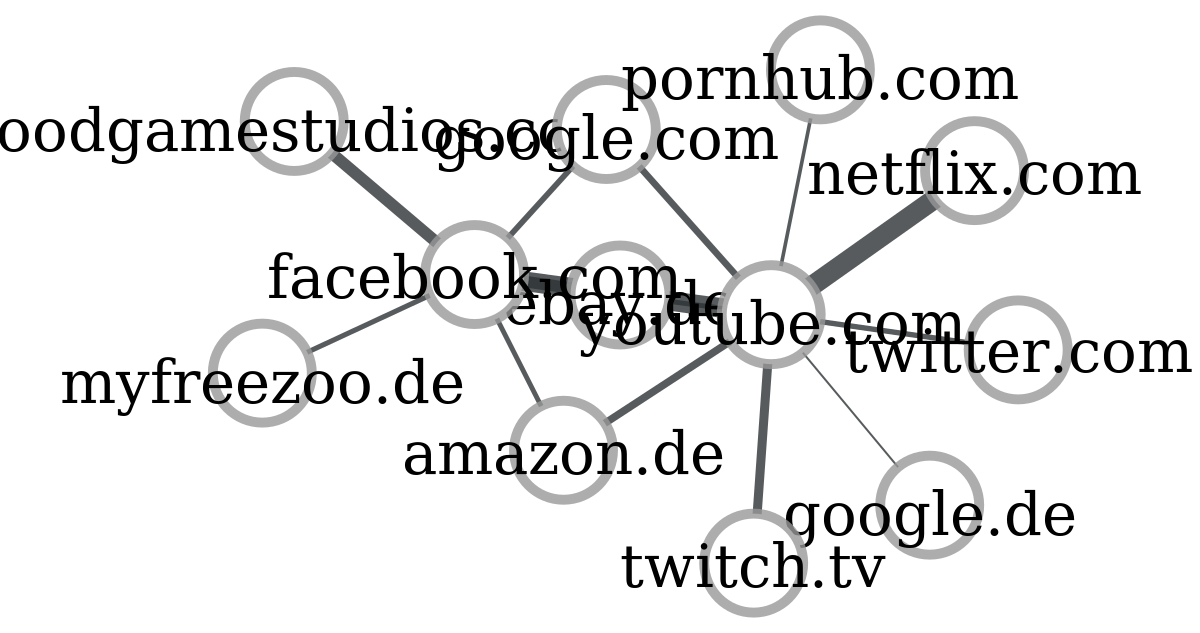

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f1803221a50, at 0x7f18032128d0>

In [59]:
gt.graph_draw(
    g = g_co_browsing_lcc, 
    vertex_text = g_co_browsing_lcc.vp.top_level_domain, 
    vertex_text_position = -2, 
    vertex_fill_color = 'white', 
    edge_pen_width = gt.prop_to_size(prop=g_co_browsing_lcc.ep.weight, mi=1, ma=10)
)

In [60]:
browsing_cat_sum = browsing[['panelist_id', 'top_level_domain_id', 'category_name_top_id', 'active_seconds']].groupby(['panelist_id', 'top_level_domain_id', 'category_name_top_id']).sum().reset_index()

DEBUG:

In [62]:
co_browsing_cat = cs.co_occurrence(
    node_list_u = panelists, 
    node_list_v = top_level_domains, 
    edge_list = browsing_cat_sum, 
    node_u_identifier = 'panelist_id', 
    node_v_identifier = 'top_level_domain_id', 
    weight = 'active_seconds', 
    norm = None, 
    category_identifier = 'category_name_top_id', 
    directed = False, 
    remove_self_loops = True, 
    enrich_node_list_v = False
)

ValueError: cannot set a frame with no defined index and a scalar

***

## About this tutorial

**License**: CC BY 4.0. Distribute, remix, adapt, and build upon ``compsoc``, even commercially, as long as you credit us for the original creation.

**Suggested citation**: Lietz, H. (2025). Projecting bipartite occurrences to co-occurrences. Version 1.0 (XX.XX.XXXX). *compsoc – Computational Social Methods in Python*. Cologne: GESIS – Leibniz Institute for the Social Sciences. https://github.com/gesiscss/compsoc